In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV 
from sklearn.linear_model import Perceptron, LogisticRegressionCV, RidgeClassifierCV, SGDClassifier, PassiveAggressiveClassifier, Lasso
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,mean_absolute_error, confusion_matrix, silhouette_score
from sklearn.metrics import roc_auc_score,roc_curve, auc, classification_report,precision_score,recall_score,log_loss,f1_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, LabelEncoder, OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer,minmax_scale,PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import RBFSampler
from sklearn import tree
import pandas_bokeh
from sklearn.decomposition import PCA,KernelPCA
from sklearn.calibration import CalibratedClassifierCV
from numpy import mean, std
import pandas.testing as tm
from scipy import stats
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import ExtraTreeClassifier
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

from yellowbrick.features import PCA as PCA_YB
from yellowbrick.features.radviz import RadViz
from yellowbrick.features import pca_decomposition
from yellowbrick.features import Manifold
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import CVScores
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import ParallelCoordinates
from yellowbrick.model_selection import RFECV
from yellowbrick.classifier import ROCAUC


#other
from math import sqrt
import inspect
from matplotlib.font_manager import FontProperties
from scipy.stats import loguniform, uniform
from bokeh import io
import datetime
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import eli5
%matplotlib inline

In [2]:


DATASET_URL = "https://gist.githubusercontent.com/YHYeoh/ad1a7f7170c72d621d05a70637540152/raw/5a6059c199e2c46d2f3d258f03d93cfea98e2749/marketing_campaign.csv"
data = pd.read_csv(DATASET_URL, sep = ';')

education_order = [['Basic', 'Graduation', 'Master', '2n Cycle', 'PhD']]
ordinal_encoder = OrdinalEncoder(categories=education_order)

data["Education"] = (ordinal_encoder.fit_transform(data["Education"].values.reshape(-1, 1))).astype(int)
# print(ordinal_encoder.categories_)

#encode categorical column
categorical = ['Marital_Status']
marital_status_ohe = pd.get_dummies(data.Marital_Status,prefix="Marital")
data = data.join(marital_status_ohe)

#drop original column after encoding
data.drop(['Marital_Status'], axis = 1,inplace = True)

print(data.columns)

tunable_cols = ["Year_Birth", "Income","Dt_Customer"]


y = data.Response
X = data.drop("Response",axis=1)

numerical_bool_col = [x for x in data.columns if data[x].isin([0,1]).all()] # print(numerical_bool_col)
numerical_scalable_col = [x for x in data.columns if x not in numerical_bool_col]


Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Marital_Absurd',
       'Marital_Alone', 'Marital_Divorced', 'Marital_Married',
       'Marital_Single', 'Marital_Together', 'Marital_Widow', 'Marital_YOLO'],
      dtype='object')


In [4]:
# import pandas as pd
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

# from sklearn.preprocessing import OrdinalEncoder
# import numba
# import numpy as np
# from scipy import stats

def getKeyVal(inDict):
  for i in inDict:
    key=i
    val= inDict[i]
  return key,val

def getIterativeImputedIncome(data):
  imr = IterativeImputer(random_state=42, max_iter=100, min_value= data['Income'].min())
  imr = imr.fit(data[['Income']])
  data['Income'] = imr.transform(data[['Income']]).ravel()
  return data

def getKNNImputedIncome(data):
	imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
	data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
	return data

def getAgeFromDateBirth(data):
	year = datetime.datetime.now().year
	data['Year_Birth'] = data['Year_Birth'].apply(lambda x : year - x )
	return data

def extractFromDate(data):
	data['enroll_year'] = pd.DatetimeIndex(data.Dt_Customer).year
	data['enroll_month'] = pd.DatetimeIndex(data.Dt_Customer).month
	data['enroll_day'] = pd.DatetimeIndex(data.Dt_Customer).day
	data.drop(['Dt_Customer'], axis = 1, inplace= True)
	return data

def convertToDays(data):
	vfunc = np.vectorize(lambda x: (datetime.datetime.now() - x).days)
	data['Dt_Customer'] = vfunc(pd.DatetimeIndex(data.Dt_Customer).to_pydatetime())
	return data

def getBinnedIncome(data):
	data['Income'] = pd.cut(data['Income'], bins=[0, 15000, 60000, 110000, 700000], labels=False, precision=0).convert_dtypes()
	return data

def getNormalizedIncome(data):
    
	data = data[(np.abs(stats.zscore(data[['Income']])) < 3)]
	return data

def getNormalizedAndBinnedIncome(data):
	data = data[(np.abs(stats.zscore(data[['Income']])) < 3)]
	data['Income'] = pd.cut(data['Income'], bins=[0, 15000, 60000, 110000, 700000], labels=False, precision=0).convert_dtypes()
	return data


def getOverSamplingData(x,y):
    oversampler = RandomOverSampler(sampling_strategy=0.5)
    x,y = oversampler.fit_resample(x, y)
    return (x,y)


def getUnderSamplingData(x,y):
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    x,y = undersampler.fit_resample(x, y)
    return (x,y)

def getHypeYearBirth(data):
	hyper_year_birth = [
    {'Not age engineering':data},
		{'Age':getAgeFromDateBirth(data.copy())}
	]
	return hyper_year_birth

hyper_dt_customer = [
	{'extractFromDate':extractFromDate(data.copy())},
	{'convertToDays':convertToDays(data.copy())}
]

def getPreprocessingIncome(data):
	preprocessing_income = [
    {'getIterativeImputedIncome':getIterativeImputedIncome(data.copy())},
		{'getKNNImputedIncome':getKNNImputedIncome(data.copy())},
		{'fillNa method = ffill':data.copy().fillna(method = "ffill")}, #ffill
		{'fillNa method = bfill':data.copy().fillna(method = "bfill")}, #bfill
		{'mean imputed':data.copy().fillna(data.mean())}, #mean imputed
		{'median imputed':data.copy().fillna(data.median())}, #median imputed
		{'Income dropped':data.copy().dropna(subset=['Income'])}
	]
	return preprocessing_income

def getHypeIncome(data):
	hyper_income = [
  {'No income engineering':data},
	{'Binned Income':getBinnedIncome(data.copy())},
	{'Normalized Income':getNormalizedIncome(data.copy())},
	{'Binned and Normalized Income':getNormalizedAndBinnedIncome(data.copy())}
	]
	return hyper_income


def getDataSampling(x,y):
	hyper_oversampling = [
  {'No data sampling':(x,y)},
	{'Under sampling':getUnderSamplingData(x,y)},
	{'Over sampling':getOverSamplingData(x,y)},
	]
	return hyper_oversampling


# hyperparams = {
# 	"Year_Birth":[ data['Year_Birth'], getAgeFromDateBirth(data.copy())],	
# 	"Income": [data['Income'], getBinnedIncome(data['Income']), getNormalizedIncome()]
# }

In [7]:
def hasmethod(obj, name):
	return inspect.ismethod(getattr(obj, name, None))

def setupPreprocessPipeline(scaler,numerical_no_bool):
	ss = Pipeline(steps=[('scaler',scaler)])
	#ohe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown = 'ignore'))])
	preprocess = ColumnTransformer(
                    transformers=[
                        ('cont', ss, numerical_no_bool)
                        #('cat', ohe, categorical),
                        #('le', le, ordinal),
                        ],remainder='passthrough')
	return preprocess



    
def overallClassificationReport(model,classes):
	visualizer = ClassificationReport(model, classes=classes, support=True) #might can change
	visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
	if(model.__class__.__name__ == "XGBClassifier"): #special treatment for xgboost as it reordered column
		model.fit(X_train, y_train)
		reorderedColumn = model.get_booster().feature_names
		reordered_Xtest = X_test[reorderedColumn] #reorderColumn
		visualizer.score(X_test, y_test)        
		visualizer.show()
		return
	visualizer.score(X_test, y_test)        # Evaluate the model on the test data
	visualizer.show()


def overall_feature_importance(model,X_train,y_train):
	labels = list(map(lambda s: s.title(), X.columns))
	viz = FeatureImportances(model, labels=labels,encoder={1: 'yes',0: 'no'}, relative=False, topn = 8)
	viz.fit(X, y)
	viz.show()

def has_feature_imp(classifier):
	status = False
	if (hasattr(classifier,'coef_')):
		status = True
	elif (hasattr(classifier,'coefs_')):
		status = True
	elif (hasattr(classifier,'feature_importances_')):
		status = True
	print("Cannot extract feature importance, skipping")
	return status


In [5]:
def cross_validate(classifier, cv,X_train,y_train,dtColumnStatus
                   ,incomePreproStatus,IncomeEngiStatus,yearProcessStatus,dataSamplingStatus,numerical_no_bool):
	scalers = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(), RobustScaler(),QuantileTransformer()]
	train_acc = []
	test_acc = []
	mean = []
	result = []
	for scaler in scalers:
		preprocess = setupPreprocessPipeline(scaler,numerical_no_bool)
		pipeline = Pipeline(steps=[
	        ('preprocess', preprocess),
	        ('classifier', classifier)
		])

		train_acc = []
		test_acc = []
		train_recall = []
		test_recall = []
		train_precision = []
		test_precision = []
		train_f1 = []
		test_f1 = []
		train_auc_roc = []
		test_auc_roc = []
		mean = []
		
		for train_ind, val_ind in cv.split(X_train, y_train):
			X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind]
			pipeline.fit(X_t, y_t)
			y_hat_t = pipeline.predict(X_t)
			train_acc.append(accuracy_score(y_t, y_hat_t))
			train_recall.append(recall_score(y_t, y_hat_t))
			train_precision.append(precision_score(y_t, y_hat_t))
			train_f1.append(f1_score(y_t, y_hat_t))
			train_auc_roc.append(roc_auc_score(y_t, y_hat_t))
			X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind] 
			y_hat_val = pipeline.predict(X_val)
			test_acc.append(accuracy_score(y_val, y_hat_val))
			test_recall.append(recall_score(y_val, y_hat_val))
			test_precision.append(precision_score(y_val, y_hat_val))
			test_f1.append(f1_score(y_val, y_hat_val))
			test_auc_roc.append(roc_auc_score(y_val, y_hat_val))
            
		model_result.append({
            'classifier':classifier.__class__.__name__,
            'scalerName':scaler.__class__.__name__,
            'dataSampling':dataSamplingStatus,
            'dtColumn':dtColumnStatus,
            'incomePreprocessing':incomePreproStatus,
            'IncomeEngineering':IncomeEngiStatus,
            'yearProcess':yearProcessStatus,
            'train_accuracy':np.mean(train_acc),
            'test_accuracy':np.mean(test_acc),
            'train_recall':np.mean(train_recall),
            'test_recall':np.mean(test_recall),
            'train_precision':np.mean(train_precision),
            'test_precision':np.mean(test_precision),
            'train_f1':np.mean(train_f1),
            'test_f1':np.mean(test_f1),
            'train_auc_roc':np.mean(train_auc_roc),
            'test_auc_roc':np.mean(test_auc_roc)
        })

	return result

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
models = [
	#Lasso(),
# 	SGDClassifier(max_iter = 1000, tol=1e-3,penalty = "elasticnet"),
# 	LinearSVC(), 
# 	GaussianProcessClassifier(),
# 	ExtraTreesClassifier(), 
# # 	BernoulliNB(),
	LogisticRegressionCV(max_iter= 1200), 
# 	RidgeClassifierCV(),
	SVC(kernel = 'linear',max_iter= -1), 
# 	Perceptron(),
# 	PassiveAggressiveClassifier(), 
# 	DecisionTreeClassifier(), #no coef 
# 	KNeighborsClassifier(),#no feat_import, use permutation_importance 
# 	GaussianNB(), #no feat_import, use permutation_importance 
	LGBMClassifier(),#no coef 
	RandomForestClassifier(), #no coef 
# 	GradientBoostingClassifier(),#no coef 
# 	PassiveAggressiveClassifier(), 
# 	ExtraTreesClassifier(), #no coef 
	XGBClassifier(),
# 	AdaBoostClassifier(), #no coef
# 	MLPClassifier() #mlp not working
	]
tunable_cols = ["Year_Birth", "Income","Dt_Customer"]
model_result= []
classes = ["no", "yes"]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
problemSet=None;
counter=0;
for processed_dt_cust in hyper_dt_customer:
  dtColumnMethod,data= getKeyVal(processed_dt_cust)
  for preprocessed_income in getPreprocessingIncome(data):
    incomePreprocessMethod,data= getKeyVal(preprocessed_income)
    for processed_income_col in getHypeIncome(data):
      incomeEngineeringMethod,data= getKeyVal(processed_income_col)
      for processed_year_birth in getHypeYearBirth(data):
        processYearMethod,data = getKeyVal(processed_year_birth) # print(data)
        numerical_bool_col = [x for x in data.columns if data[x].isin([0,1]).all()] # print(numerical_bool_col)
        numerical_scalable_col = [x for x in data.columns if x not in numerical_bool_col]
        y = data.Response # print(y.value_counts())
        X = data.drop(['Response'], axis=1)
        #should auto drop columns based on pearson correlation , feature importance
        #X.drop(['NumStorePurchases','NumCatalogPurchases','MntFruits','MntFishProducts','MntSweetProducts','MntWines'], axis = 1, inplace = True)
        

    #             print("Dt                : ",dtColumnMethod,"\n")
    #             print("Preprocess Income : ",incomePreprocessMethod,"\n")
    #             print("Income Engineering: ",incomeEngineeringMethod,"\n")
    #             print("Process Year      : ",processYearMethod,"\n") # print(numerical_scalable_col) # print(data.info())
    #             print("Data Sampling     : ",dataSamplingDesc,"\n")
              
      
        for model in models:
            x_dropped_data = X.drop([x for x in X.columns if x not in classifier_columns[model.__class__.__name__]],axis = 1)
            nummerical_no_bool = [x for x in numerical_scalable_col if x in x_dropped_data.columns]
            
            X_train, X_test, y_train, y_test = train_test_split(x_dropped_data,y, test_size=0.25, random_state=42)
            for dataSamplingMethod in getDataSampling(X_train,y_train):
              dataSamplingDesc,data= getKeyVal(dataSamplingMethod)
              X_train,y_train = data
#             print(X_train.isnull().values.any(),y_train.isnull().values.any(),"\n")
              if(X_train.isnull().values.any()==True):
                  problemSet = X_train
                  print(X_train.isnull())
                  break
              counter+=1
              if(counter%100==0):
                  print("Counter : ",counter)
              model_result.append(cross_validate(model,StratifiedKFold(),X_train,y_train,dtColumnMethod,incomePreprocessMethod
                                                    ,incomeEngineeringMethod,processYearMethod,dataSamplingDesc,nummerical_no_bool))
  #                 overallClassificationReport(model,classes)
#                 if hasmethod(model, 'predict_proba'):
#                     ROC_Curve_Plot(model,X_test,y_test,"Overall "+model.__class__.__name__)
#                 if has_feature_imp(model) :
#                     overall_feature_importance(model,X_train, y_train)

In [25]:
resultDF = pd.DataFrame.from_records(model_result,columns=['classifier','scalerName','dataSampling','dtColumn'
                                                           ,'incomePreprocessing','IncomeEngineering','yearProcess'
                                                           ,'train_accuracy','test_accuracy','train_recall','test_recall'
                                                           ,'train_precision','test_precision','train_f1','test_f1',
                                                          'train_roc_auc','test_roc_auc'])
resultDF=resultDF.dropna(how='all')

# roc_auc
# f1

In [ ]:
resultDF.isnull().values.any()

In [ ]:
accColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_accuracy','test_accuracy']
resultDF[accColumn].sort_values('test_accuracy',ascending=False)

In [ ]:
recallColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_recall','test_recall']
resultDF[recallColumn].sort_values('test_recall',ascending=False)

In [ ]:
precColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_precision','test_precision']
resultDF[precColumn].sort_values('test_precision',ascending=False)

In [ ]:
f1Column=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_f1','test_f1']
resultDF[f1Column].sort_values('test_f1',ascending=False)

In [ ]:
roc_aucColumn=['classifier','scalerName','dataSampling','dtColumn','incomePreprocessing','IncomeEngineering','yearProcess','train_roc_auc','test_roc_auc']
resultDF[roc_aucColumn].sort_values('test_roc_auc',ascending=False)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [4]:
#svc xgb, rfc, lgbm, logistic
from sklearn.linear_model import LogisticRegression
scoring = 'f1'
fold=10
# featureNumList = list(range(1,X_train.shape[1]))
modelsWithParam = [
         { 
        'model':LogisticRegression(),'param':{'C': np.logspace(-3,3,7),#100,10,1, 0.1, 0.01, 0.001
#                                  'fit_intercept':[True,False],
#                                  'dual':[True,False],
#                                  'penalty':['l2'],
#                                  'max_iter':list(range(100,1000,100)),#[50,100,500,1000,2000,4000,8000]
#                                  'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
        }},
    {
        'model':LGBMClassifier(),'param':{
        'boosting_type':["gbdt","dart","goss","rf"],
        'metric':['binary_logloss'],
#         'sub_feature':list(np.arange(0.1,1,10)),
#         'num_leaves':list(range(10,50,10)),
#         'learning_rate': [1,0.1,0.01,0.005,0.001],
#         'n_estimators': list(range(100,1000,100)),
#         'min_data':[50],
#         'max_depth': list(range(5,20,5)),
#         'min_split_gain':list(np.arange(0.1,1,10)),
#         'random_state': [42]
    }},
    {
        'model':RandomForestClassifier(),'param':{
            'bootstrap': [True, False],
#              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#              'max_features': ['auto', 'sqrt'],
#              'min_samples_leaf': [1, 2, 4],
#              'min_samples_split': [2, 5, 10],
#              'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
    }},
    {
        'model':XGBClassifier(),'param':{
            'n_estimators': [400] #, 700, 1000],
#             'colsample_bytree': [0.7, 0.8],
#             'max_depth': [15,20,25],
#             'reg_alpha': [1.1, 1.2, 1.3],
#             'reg_lambda': [1.1, 1.2, 1.3],
#             'subsample': [0.7, 0.8, 0.9]
        }
    },
    {
            
        'model':SVC(),'param':{
         'C': [ 1,0.1] #,10, 100, 1000],  
#         'gamma': [0.0001,0.00001], 
#         'kernel': ['linear', 'rbf'],
#         'random_state': [42] 
    }}
    
    
    
#     { split svc into 2 as svc poly and non-poly kernel has
#         #different parameter
#         'model':SVC(),'param':{
#         'C': [0.1, 1, 10, 100, 1000],  
#         'gamma': [1,0.1,0.01,0.005,0.001,0.0005,0.0001], 
#         'kernel': ['poly'],
#         'degree':list(range(3,10)),
#         'random_state': [42],
#     }}

#         {
#         'model':LogisticRegression(),'param':{'Cs': [[100,10,1, 0.1,0.05,0.001,0.0001]],#100,10,1, 0.1, 0.01, 0.001
#                                  'fit_intercept':[True,False],
#                                  'normalize':[True,False],
#                                  'penalty':['elasticnet'],
#                                  'penalty':[True],
#                                  'max_iter':list(range(100,1000,100)),#[50,100,500,1000,2000,4000,8000]
#                                  'solver':['saga'],
#                                  'random_state':[42]
#         }}
]




In [6]:
#defines column to drop for each classifier
classifier_columns = {
		"SVC":["AcceptedCmp2","AcceptedCmp5","MntSweetProducts","Complain","MntWines","Year_Birth","MntGoldProds","NumDealsPurchases"],
		"LGBMClassifier":["Kidhome","MntWines","Education","Teenhome","AcceptedCmp4","MntFishProducts","AcceptedCmp2","AcceptedCmp5"],
		"RandomForestClassifier":["Kidhome","Teenhome","Education","MntWines","MntFishProducts","AcceptedCmp4","AcceptedCmp5","AcceptedCmp2"],
		"XGBClassifier":["AcceptedCmp2","AcceptedCmp5","Complain","Marital_Together","Marital_Married","NumDealsPurchases","Kidhome","Year_Birth"],
		"LogisticRegression":["AcceptedCmp2","AcceptedCmp5","Complain","AcceptedCmp1","enroll_year","Marital_Married","Marital_Together","Year_Birth"]
}

In [7]:
#randomised search cv
from sklearn.kernel_approximation import Nystroem
scoring = "accuracy"
fold=4
def modelBestFit(item,X_trains,y_trains,X_tests,y_tests):
    model = item['model']
    paramGrid = item['param']
    search = RandomizedSearchCV(estimator=model, param_distributions= paramGrid
                                ,n_iter=200,n_jobs=-1,pre_dispatch='1*n_jobs'
                                ,scoring = scoring,refit = True,cv=fold
                                ,random_state=42)
    search.fit(X_trains,y_trains.values)
    test_score =search.score(X_tests,y_tests.values)
    model_name = model.__class__.__name__
    return {'model_name':model_name,'test_score':test_score,'best_score':search.best_score_,'best_model':search.best_estimator_}

def bestModel(modelsAndParams):
    modelPerformance = pd.DataFrame()
    for item in modelsAndParams:
        
        model = item['model']
        
        x_copy = X.copy()
        x_copy = x_copy.drop([x for x in x_copy.columns if x not in classifier_columns[model.__class__.__name__]],axis = 1)
        
        X_train, X_test, y_train, y_test = train_test_split(x_copy,y, test_size=0.25, random_state=42)
        
        X_train= X_train.fillna(method = "ffill")
        X_test = X_test.fillna(method = "ffill")
        
        if('Dt_Customer' in x_copy.columns):
            X_train = extractFromDate(X_train)
            X_test = extractFromDate(X_test)
        
        if('Income' in x_copy.columns):
            X_train = getNormalizedAndBinnedIncome(X_train)
            X_test = getNormalizedAndBinnedIncome(X_test)
        
        y_train = y_train[y_train.index.isin(X_train.index)]
        y_test = y_test[y_test.index.isin(X_test.index)]
        oversampler = RandomOverSampler(sampling_strategy=0.5,random_state=42)
        X_train,y_train = oversampler.fit_resample(X_train, y_train)
        
        qt = QuantileTransformer(random_state=42)
        X_train = qt.fit_transform(X_train)
        X_test = qt.transform(X_test)
        
        nystroem = Nystroem()
        
        X_train_transformed = nystroem.fit_transform(X_train)
        X_test_transformed = nystroem.transform(X_test)

        print(X_train_transformed.shape)
        print(X_test_transformed.shape)

        result = modelBestFit(item,X_train_transformed,y_train,X_test_transformed,y_test)
        modelPerformance = modelPerformance.append(result,ignore_index=True)
        print(result)
        
    modelPerformance.sort_values(by='test_score',ascending=False,inplace=True)
    return modelPerformance
 
result = bestModel(modelsWithParam)

(2148, 100)
(560, 100)


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 7 is smaller than n_iter=200. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=200. Running 4 iter

{'model_name': 'LogisticRegression', 'test_score': 0.8392857142857143, 'best_score': 0.7644320297951583, 'best_model': LogisticRegression(C=1000.0)}
(2148, 100)
(560, 100)


KeyboardInterrupt: 

Voting Type :  hard
Classifiers:  SVC LogisticRegression LGBMClassifier


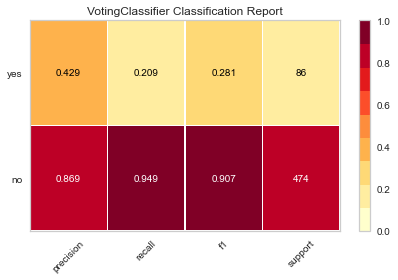

Voting Type :  soft
Classifiers:  LogisticRegression LGBMClassifier


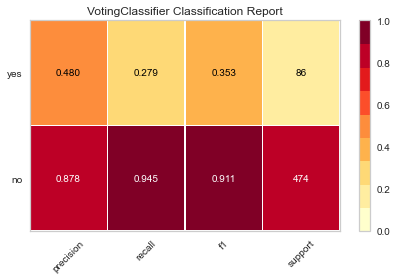

In [89]:
softHardClassificationReport(result)

In [13]:
def softHardClassificationReport(result):
    top_3 = result.sort_values(by='test_score',ascending=False).head(n=3)
    top_3 = top_3.reset_index().drop('index',axis=1)
    nofOfClassifier=3
    classList = []
    best_model_name = top_3['model_name'][0]
    topColumns = classifier_columns[best_model_name]


    x_copy = X.copy()
    x_copy = x_copy.drop([x for x in x_copy.columns if x not in classifier_columns[best_model_name]],axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(x_copy,y, test_size=0.25, random_state=42)

    X_train= X_train.fillna(method = "ffill")
    X_test = X_test.fillna(method = "ffill")

    if('Dt_Customer' in x_copy.columns):
        X_train = extractFromDate(X_train)
        X_test = extractFromDate(X_test)

    if('Income' in x_copy.columns):
        X_train = getNormalizedAndBinnedIncome(X_train)
        X_test = getNormalizedAndBinnedIncome(X_test)

    y_train = y_train[y_train.index.isin(X_train.index)]
    y_test = y_test[y_test.index.isin(X_test.index)]
    oversampler = RandomOverSampler(sampling_strategy=0.5,random_state=42)
    X_train,y_train = oversampler.fit_resample(X_train, y_train)

    qt = QuantileTransformer(random_state=42)
    X_train = qt.fit_transform(X_train)
    X_test = qt.transform(X_test)

    nystroem = Nystroem()

    X_train_transformed = nystroem.fit_transform(X_train)
    X_test_transformed = nystroem.transform(X_test)


    for i in range(nofOfClassifier):
        model_name = top_3['model_name'][i]
        model = top_3['best_model'][i]
        classList.append((model_name,model))
        votingOption=['hard','soft']

    for voteType in votingOption:
        votingClassifierReport(classList,voteType,X_train_transformed,y_train,X_test_transformed,y_test)

In [14]:
from sklearn.kernel_approximation import Nystroem

classList = [(('SVC',SVC(C=1000, gamma=0.0001, kernel='linear', random_state=42))),
            (('LogisticRegression',LogisticRegression(C=100.0, solver='newton-cg'))),
            ('LGBMClassifier',LGBMClassifier(max_depth=15, metric='binary_logloss', min_data=50,
               min_split_gain=0.1, n_estimators=800, num_leaves=40,
               random_state=42, sub_feature=0.1))]

best_model_name = 'SVC'
topColumns = classifier_columns['SVC']


x_copy = X.copy()
x_copy = x_copy.drop([x for x in x_copy.columns if x not in classifier_columns[best_model_name]],axis = 1)

X_train, X_test, y_train, y_test = train_test_split(x_copy,y, test_size=0.25, random_state=42)

X_train= X_train.fillna(method = "ffill")
X_test = X_test.fillna(method = "ffill")

if('Dt_Customer' in x_copy.columns):
    X_train = extractFromDate(X_train)
    X_test = extractFromDate(X_test)

if('Income' in x_copy.columns):
    X_train = getNormalizedAndBinnedIncome(X_train)
    X_test = getNormalizedAndBinnedIncome(X_test)

y_train = y_train[y_train.index.isin(X_train.index)]
y_test = y_test[y_test.index.isin(X_test.index)]
oversampler = RandomOverSampler(sampling_strategy=0.5,random_state=42)
X_train,y_train = oversampler.fit_resample(X_train, y_train)

qt = QuantileTransformer(random_state=42)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

nystroem = Nystroem()

X_train_transformed = nystroem.fit_transform(X_train)
X_test_transformed = nystroem.transform(X_test)

print(y_test)
# for i in range(3):
#     model_name = top_3['model_name'][i]
#     model = top_3['best_model'][i]
#     classList.append((model_name,model))
#     votingOption=['hard','soft']
votingOption=['hard','soft']
# print(X_train_transformed.shape)
# print(y_train.shape)


# print(X_test_transformed.shape)
# print(y_test.shape)

voting = VotingClassifier(estimators=classList, voting='hard')
voting = voting.fit(X_train_transformed,y_train)
train_predict = voting.predict(X_train_transformed)
print("Train roc_auc_Score : ",roc_auc_score(y_train, train_predict))
test_predict = voting.predict(X_test_transformed)
print("Train roc_auc_Score : ",roc_auc_score(y_test, test_predict))


# votingClassifierReport(classList,'hard',X_train_transformed,y_train,X_test_transformed,y_test)


324     0
96      0
2104    0
1259    0
1061    0
       ..
2185    0
1995    1
305     0
209     1
1511    0
Name: Response, Length: 560, dtype: int64
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=50. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.1. Current value: feature_fraction=0.1
Train roc_auc_Score :  0.6847067039106145
Train roc_auc_Score :  0.5803895594151702


In [40]:
import os
import pickle
import warnings

def overallClassificationReport(model,classes,X_train,y_train,X_test,y_test):
	visualizer = ClassificationReport(model, classes=classes, support=True) #might can change
	visualizer.fit(X_train, y_train.values.reshape(-1, 1))        # Fit the visualizer and the model
	visualizer.score(X_test, y_test.values)        # Evaluate the model on the test data
	visualizer.show()
def votingClassifierReport(classifiers,votingT,X_train,y_train,X_test,y_test):
    warnings.filterwarnings("ignore")
    usableClassifier = []
    if(votingT =='soft'):
        for i in classifiers:
            if hasattr(i[1],'predict_proba'):
                usableClassifier.append(i)
    else:
        usableClassifier = classifiers
    classes =['no','yes']
    #majority voting
#     in_use_classifiers=""
#     for i in classifiers:
#         in_use_classifiers = in_use_classifiers+" "+str(i[1].__class__.__name__)
#     print("Voting Type : ",votingT)
#     print("Classifiers: "+in_use_classifiers)
    voting = VotingClassifier(estimators=classifiers, voting='hard')
#     voting.train
#     pkl_filename = "{}votingClassifier.pkl".format(votingT)
# #     if os.path.exists(pkl_filename):
#         with open(pkl_filename, 'rb') as file:  
#             voting = pickle.load(file)
#     else:
#         voting = voting.fit(X_train,y_train)
    X_train = pd.DataFrame(X_train)
    y_train = pd.DataFrame(y_train)
    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test)
    
    voting = voting.fit(X_train,y_train)
    train_predict = voting.predict(X_train)
    print("Train roc_auc_Score : ",roc_auc_score(y_train, train_predict))
    test_predict = voting.predict(X_test)
    print("Train roc_auc_Score : ",roc_auc_score(y_test, test_predict))
#     with open(pkl_filename, 'wb') as file:
#         pickle.dump(model, file)
#     overallClassificationReport(voting,classes,X_train,y_train,X_test,y_test)
#     warnings.filterwarnings("default")